In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

np.random.seed = 43

In [81]:
class Bandit(object):
    def __init__(self, k_arm=10, epsilon=0.0, initial=0.0, step_size=0.1, sample_averages=False, nonstationary=False, upper_confidence_bound=None, gradient=False, gradient_baseline=False, true_reward=0.0):
        self.k_arm = k_arm
        self.epsilon = epsilon
        self.initial = initial
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.nonstationary = nonstationary
        self.upper_confidence_bound = upper_confidence_bound
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.true_reward = true_reward

        np.random.seed =43
        self.time = 0
        self.indices = np.arange(self.k_arm, dtype=np.int)

    def reset(self):
        self.q_true = np.random.normal(loc=0, scale=1, size=self.k_arm) + self.true_reward
        self.q_estimation = np.zeros(self.k_arm) + self.initial

        self.time = 0
        self.action_count = np.zeros(self.k_arm)
        self.best_action = np.argmax(self.q_true)
        self.average_reward = 0
    
    def act(self):
        if np.random.random_sample() < self.epsilon:
            return np.random.choice(self.indices)
        
        if self.upper_confidence_bound is not None:
            UCB_estimation = self.q_estimation + self.upper_confidence_bound * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)

            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])
    
    def step(self, action):
        if self.nonstationary:
            self.q_true = q_true + np.random.normal(loc=0, scale=0.01)
            self.best_action = np.argmax(self.q_true)

        reward = np.random.normal(loc=self.q_true, scale=1)[action]

        self.time += 1
        self.action_count[action] += 1
        self.average_reward = self.average_reward + (reward - self.average_reward) / self.time

        # sample averages
        if self.sample_averages:
            self.q_estimation[action] = self.q_estimation[action] + (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k_arm)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation = self.q_estimation + self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            self.q_estimation[action] = self.q_estimation[action] + self.step_size * (reward - self.q_estimation[action])

        return reward

In [14]:
def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_count = np.zeros(rewards.shape)

    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward

                if action == bandit.best_action:
                    best_action_count[i, r, t] = 1
    mean_best_action_count = best_action_count.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_count, mean_rewards

In [15]:
def figure_2_1():
    plt.violinplot(dataset=np.random.randn(200, 10) + np.random.normal(loc=0, scale=1, size=10))
    plt.xlabel("Action")
    plt.ylabel("Reward distribution")
    plt.show()

In [16]:
def figure_2_2(runs=2000, time=1000):
    epsilons = [0, 0.1, 0.01]
    bandits = [Bandit(epsilon=eps) for eps in epsilons]
    best_action_counts, rewards = simulate(runs, time, bandits)

    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    for eps, reward in zip(epsilons, rewards):
        plt.plot(reward, label="epsilon = {:.02f}".format(eps))
    plt.xlabel("steps")
    plt.ylabel("average reward")
    plt.legend()

    plt.subplot(2, 1, 2)
    for eps, counts in zip(epsilons, best_action_counts):
        plt.plot(counts, label="epsilon = {:.02f}".format(eps))
    plt.xlabel("steps")
    plt.ylabel("% optimal action")
    plt.ylim((0, 1))
    plt.legend()

    plt.show()

In [17]:
def exercise_2_5(runs=2000, time=10000):
    bandits = [
        Bandit(epsilon=0.1, sample_averages=True),
        Bandit(epsilon=0.1, step_size=0.1)]
    best_action_counts, rewards = simulate(runs, time, bandits)

    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    plt.plot(rewards[0], label="epsilon = {:.02f}".format(0.1))
    plt.plot(rewards[1], label="epsilon = {:.02f}, step_size = {:0.1f}".format(0.1, 0.1))
    plt.xlabel("steps")
    plt.ylabel("average reward")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(best_action_counts[0], label="epsilon = {:.02f}".format(0.1))
    plt.plot(best_action_counts[1], label="epsilon = {:.02f}, step_size = {:0.1f}".format(0.1, 0.1))
    plt.xlabel("steps")
    plt.ylabel("% optimal action")
    plt.ylim((0, 1))
    plt.legend()

    plt.show()

In [63]:
def figure_2_3(runs=2000, time=1000):
    bandits = [
        Bandit(epsilon=0.1),
        Bandit(epsilon=0, initial=5)]
    best_action_counts, rewards = simulate(runs, time, bandits)

    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    plt.plot(rewards[0], label="epsilon = {:.02f}".format(0.1))
    plt.plot(rewards[1], label="epsilon = {:.02f}, step_size = {:0.1f}".format(0.1, 0.1))
    plt.xlabel("steps")
    plt.ylabel("average reward")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(best_action_counts[0], label="epsilon = {:.02f}".format(0.1))
    plt.plot(best_action_counts[1], label="epsilon = {:.02f}, step_size = {:0.1f}".format(0.1, 0.1))
    plt.xlabel("steps")
    plt.ylabel("% optimal action")
    plt.ylim((0, 1))
    plt.legend()

    plt.show()

In [35]:
def figure_2_4(runs=2000, time=1000):
    bandits = [
        Bandit(epsilon=0.1),
        Bandit(epsilon=0.0, upper_confidence_bound=1),
        Bandit(epsilon=0.0, upper_confidence_bound=2)]
    best_action_counts, rewards = simulate(runs, time, bandits)

    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    plt.plot(rewards[0], label="epsilon = {:.02f}".format(0.1))
    plt.plot(rewards[1], label="UCB c = {}".format(1))
    plt.plot(rewards[2], label="UCB c = {}".format(2))
    plt.xlabel("steps")
    plt.ylabel("average reward")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(best_action_counts[0], label="epsilon = {:.02f}".format(0.1))
    plt.plot(best_action_counts[1], label="UCB c = {}".format(1))
    plt.plot(best_action_counts[2], label="UCB c = {}".format(2))
    plt.xlabel("steps")
    plt.ylabel("% optimal action")
    plt.ylim((0, 1))
    plt.legend()

    plt.show()

In [83]:
def figure_2_5(runs=2000, time=1000):
    step_sizes = [0.1, 0.4]
    bandits = [ 
        Bandit(step_size=step_size, gradient=True, true_reward=4) 
        for step_size in step_sizes ]
    bandits_baseline = [ 
        Bandit(step_size=step_size, gradient=True, true_reward=4, gradient_baseline=True) 
        for step_size in step_sizes ]

    best_action_counts, rewards = simulate(runs, time, bandits)
    best_action_counts_baseline, rewards_baseline = simulate(runs, time, bandits_baseline)

    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    for step_size, reward in zip(step_sizes, rewards):
        plt.plot(reward, label="step_size = {}".format(step_size))
    for step_size, reward_baseline in zip(step_sizes, rewards_baseline):
        plt.plot(reward_baseline, label="step_size = {}, baseline".format(step_size))
    plt.xlabel("steps")
    plt.ylabel("average reward")
    plt.legend()

    plt.subplot(2, 1, 2)
    for step_size, count in zip(step_sizes, best_action_counts):
        plt.plot(count, label="step_size = {}".format(step_size))
    for step_size, count_baseline in zip(step_sizes, best_action_counts_baseline):
        plt.plot(count_baseline, label="step_size = {}, baseline".format(step_size))
    plt.xlabel("steps")
    plt.ylabel("% optimal action")
    plt.ylim((0, 1))
    plt.legend()

    plt.show()

In [111]:
def figure_2_6(runs=2000, time=1000):
    labels = [
        'epsilon-greedy',
        'gradient bandit',
        'UCB',
        'optimistic initialization']
    generators = [
        lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True),
        lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True),
        lambda coef: Bandit(upper_confidence_bound=coef, sample_averages=True),
        lambda initial: Bandit(initial=initial, step_size=0.1)]
    parameters = [
        np.arange(-7, -1, dtype=np.float),
        np.arange(-5, 2, dtype=np.float),
        np.arange(-4, 3, dtype=np.float),
        np.arange(-2, 3, dtype=np.float)]

    bandits = []
    for generator, parameter in zip(generators, parameters):
        for param in parameter:
            bandits.append(generator(pow(2, param)))
        
    best_action_counts, average_rewards = simulate(runs, time, bandits)
    rewards = np.mean(average_rewards, axis=1)
    action_counts = np.mean(best_action_counts, axis=1)

    plt.figure(figsize=(10, 20))
    i = 0
    plt.subplot(2, 1, 1)
    for label, parameter in zip(labels, parameters):
        l = len(parameter)
        plt.plot(pow(2, parameter), rewards[i:i+l], label=label)
        i += l
    plt.xlabel("Parameter(2^x)")
    plt.ylabel("Average reward")
    plt.legend()

    i = 0
    plt.subplot(2, 1, 2)
    for label, parameter in zip(labels, parameters):
        l = len(parameter)
        plt.plot(pow(2, parameter), action_counts[i:i+l], label=label)
        i += l
    plt.xlabel("Parameter(2^x)")
    plt.ylabel("% optimal action")
    plt.ylim((0, 1))
    plt.legend()

    plt.show()

100%|██████████| 2000/2000 [02:26<00:00, 13.69it/s]


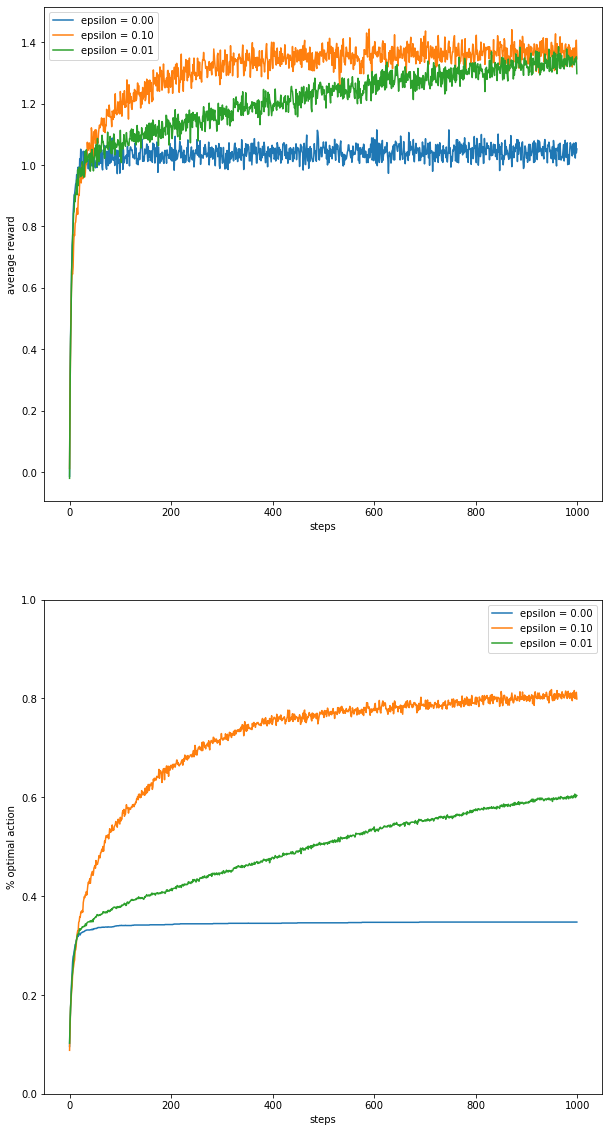

In [57]:
figure_2_2()

100%|██████████| 2000/2000 [04:09<00:00,  8.00it/s]


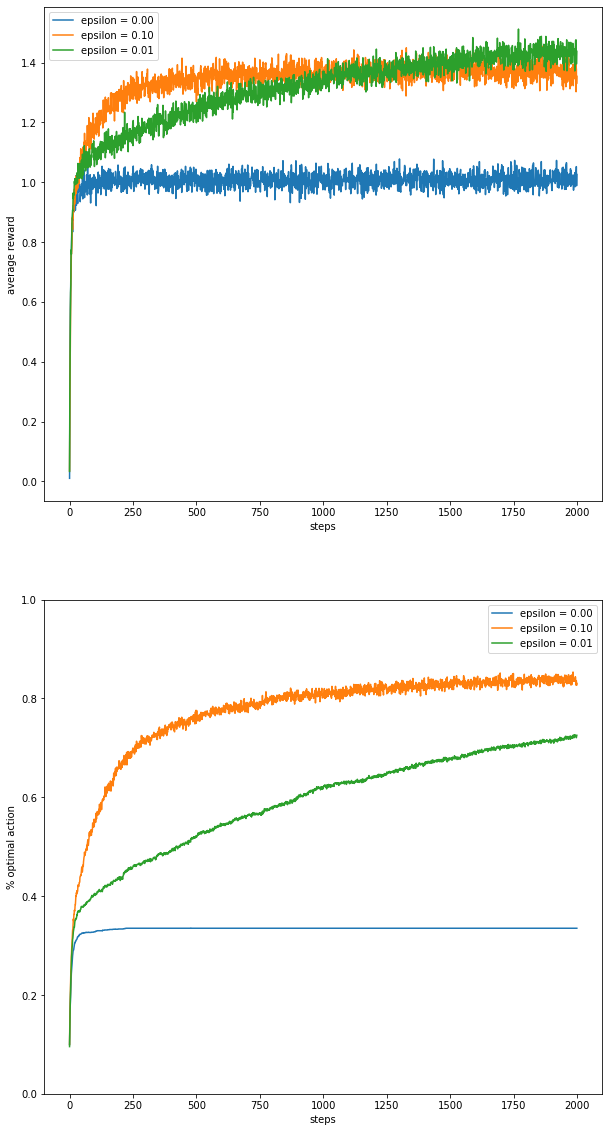

In [9]:
figure_2_2(time=2000)

100%|██████████| 2000/2000 [23:15<00:00,  1.43it/s]


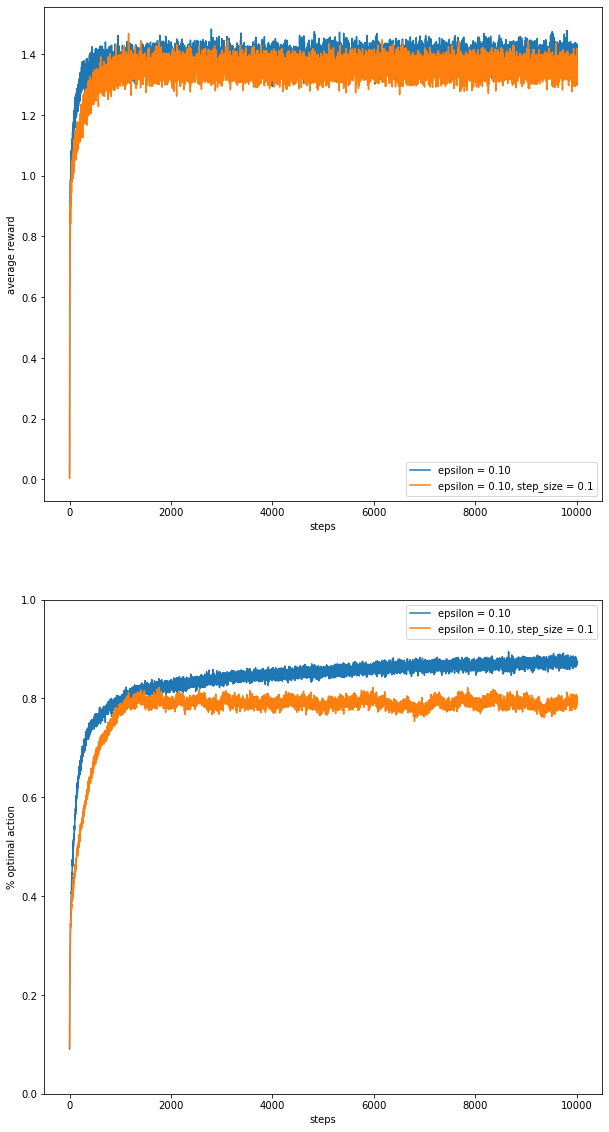

In [8]:
exercise_2_5()

100%|██████████| 2000/2000 [02:32<00:00, 13.07it/s]


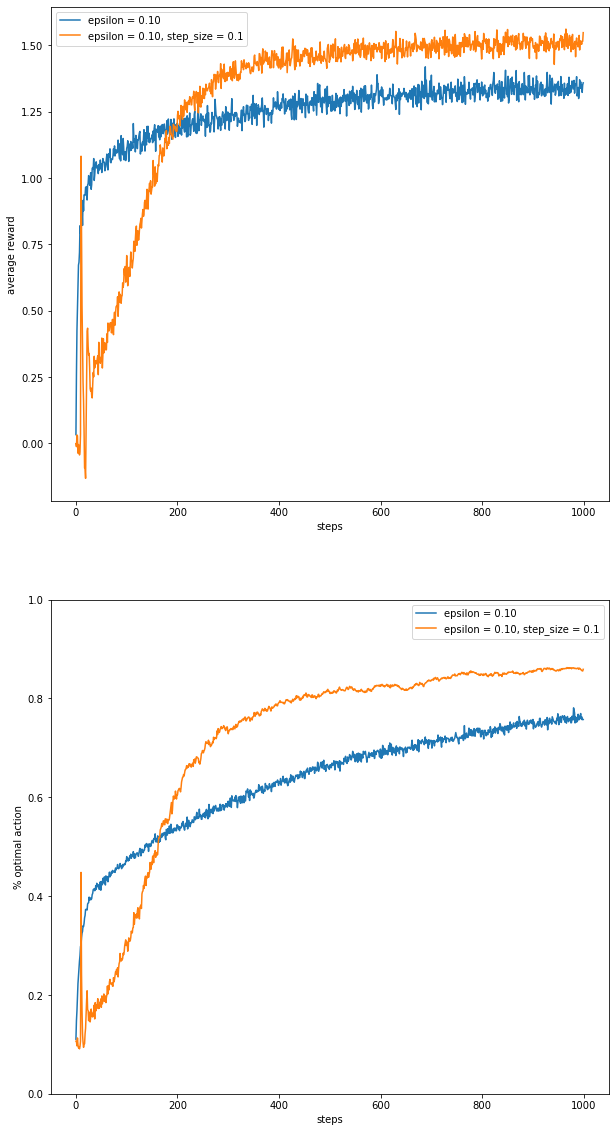

In [19]:
figure_2_3()

100%|██████████| 2000/2000 [03:11<00:00, 10.44it/s]


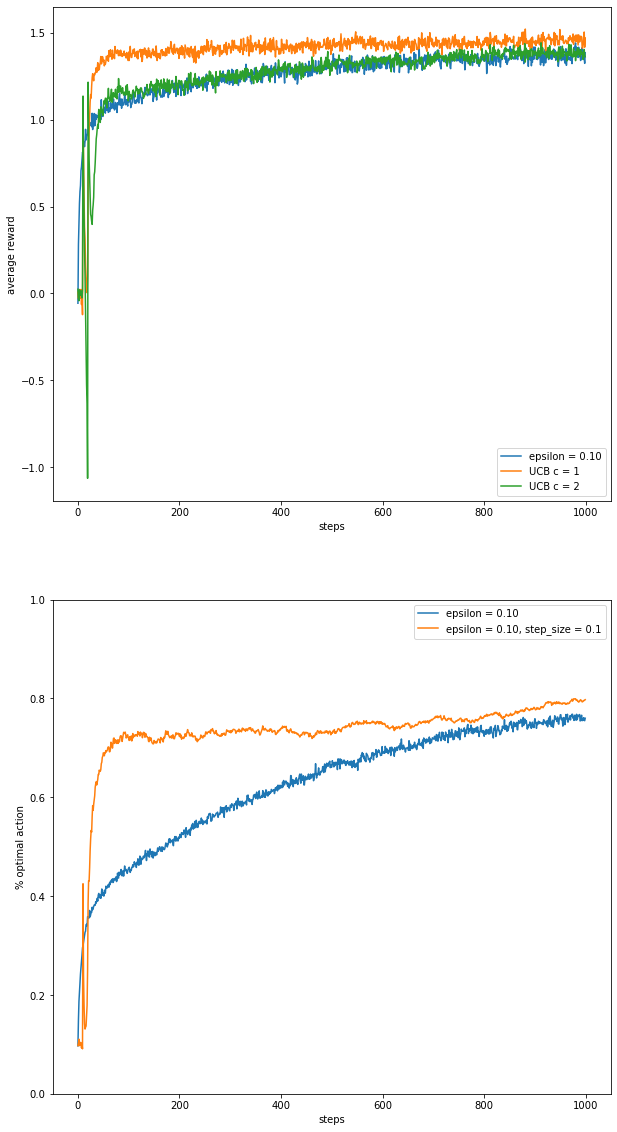

In [34]:
figure_2_4()

100%|██████████| 2000/2000 [02:36<00:00, 12.77it/s]


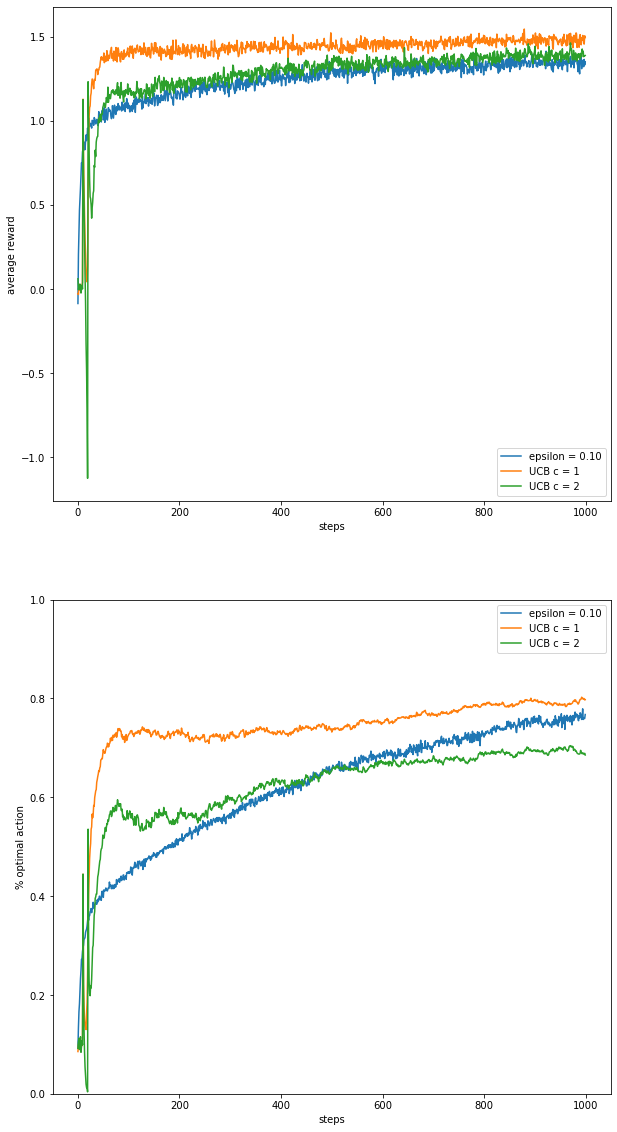

In [36]:
figure_2_4()

100%|██████████| 2000/2000 [05:28<00:00,  6.08it/s]


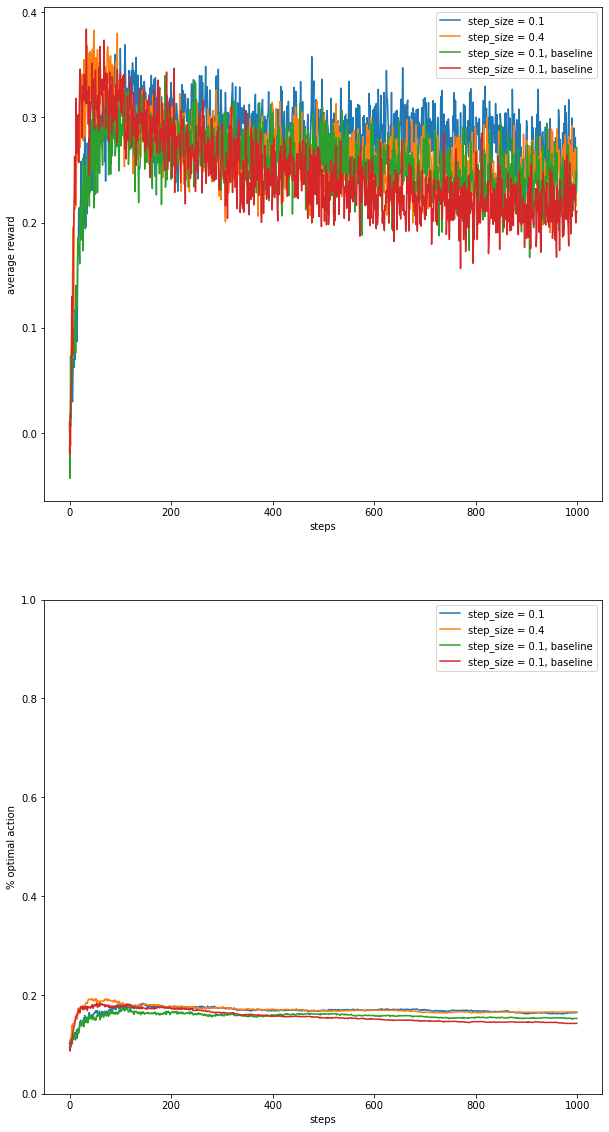

In [61]:
figure_2_5()

100%|██████████| 2000/2000 [05:36<00:00,  5.94it/s]


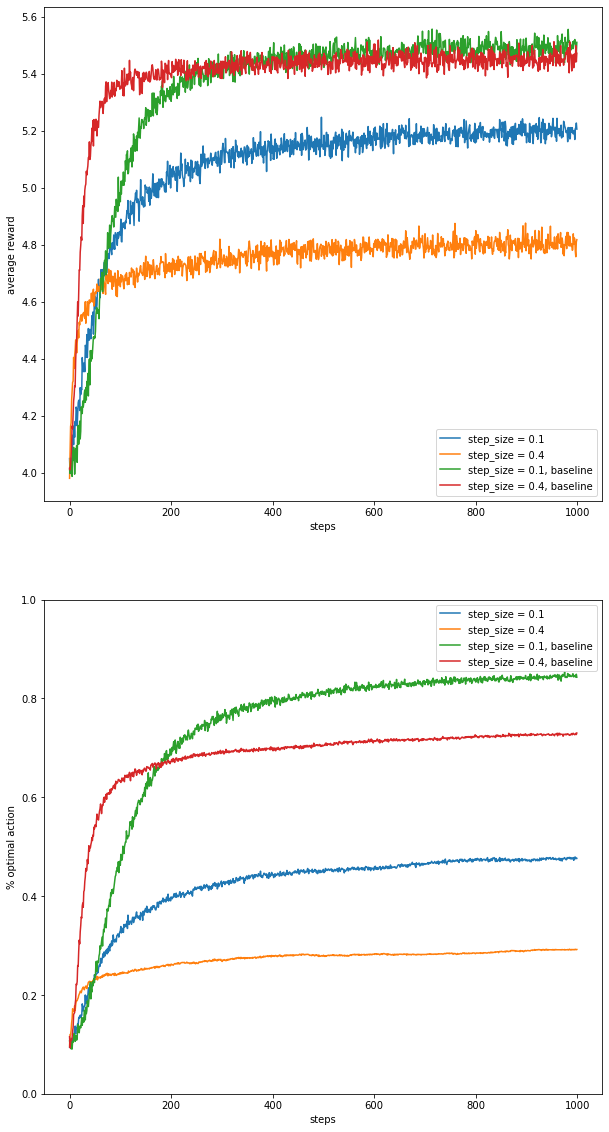

In [84]:
figure_2_5()

100%|██████████| 200/200 [00:18<00:00, 10.88it/s]


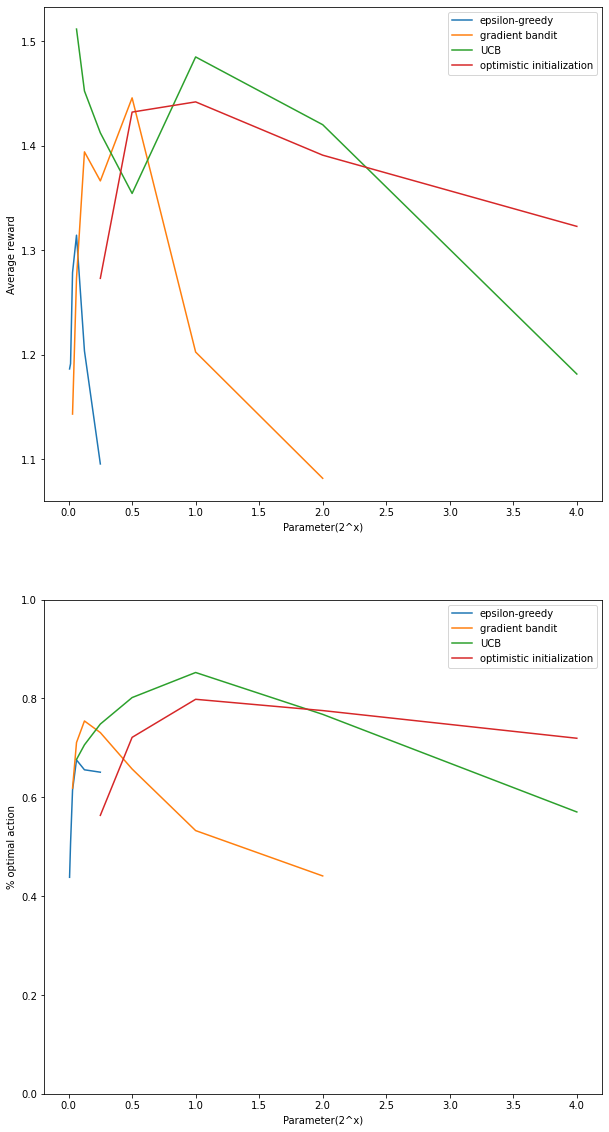

In [106]:
figure_2_6()

In [109]:

def figure_2_6(runs=2000, time=1000):
    labels = ['epsilon-greedy', 'gradient bandit',
              'UCB', 'optimistic initialization']
    generators = [lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True),
                  lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True),
                  lambda coef: Bandit(epsilon=0, upper_confidence_bound=coef, sample_averages=True),
                  lambda initial: Bandit(epsilon=0, initial=initial, step_size=0.1)]
    parameters = [np.arange(-7, -1, dtype=np.float),
                  np.arange(-5, 2, dtype=np.float),
                  np.arange(-4, 3, dtype=np.float),
                  np.arange(-2, 3, dtype=np.float)]

    bandits = []
    for generator, parameter in zip(generators, parameters):
        for param in parameter:
            bandits.append(generator(pow(2, param)))

    _, average_rewards = simulate(runs, time, bandits)
    rewards = np.mean(average_rewards, axis=1)

    i = 0
    for label, parameter in zip(labels, parameters):
        l = len(parameter)
        plt.plot(parameter, rewards[i:i+l], label=label)
        i += l
    plt.xlabel('Parameter(2^x)')
    plt.ylabel('Average reward')
    plt.legend()


In [110]:
figure_2_6()

11%|█         | 224/2000 [00:35<04:44,  6.25it/s]


KeyboardInterrupt: 